In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import tensorflow as tf
from glob import glob
import cv2
import numpy as np
import pandas as pd
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Model
import tensorflow.keras.backend as K
from keras.layers import Cropping2D
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Add, Activation, Lambda
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
import tensorflow.keras.layers as L

In [2]:
batch_size = 6
lr = 1e-3
epochs = 200
width = 256
height = 256

In [3]:
dataset_path = os.path.join("/kaggle/input/aeroscapes/aeroscapes")
files_dir = os.path.join("files", "modified_uavid_dataset")
model_file = os.path.join(files_dir, "UnetModel.keras")
log_file = os.path.join(files_dir, "Log-Unet.csv")

# Function to create directory
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
create_dir(files_dir)

In [4]:
def load_data(path):
    Images = sorted(glob(os.path.join(path, "JPEGImages", "*")))
    Labels = sorted(glob(os.path.join(path, "Visualizations", "*")))

    return (Images, Labels)

In [ ]:
(Images, Labels) = load_data(dataset_path)

print(f"New Train: {len(Images)} - {len(Labels)}")

# First, split off 10% of the data for testing
train_val_images, test_x, train_val_labels, test_y = train_test_split(Images, Labels, test_size=0.1, random_state=42)

# Then, split the remaining 90% into 70% training and 20% validation (0.7 / 0.9 ≈ 0.78)
train_x, valid_x, train_y, valid_y = train_test_split(train_val_images, train_val_labels, test_size=0.22, random_state=42)

print(f"Training set: {len(train_x)} images")
print(f"Validation set: {len(valid_x)} images")
print(f"Test set: {len(test_x)} images")

# Now, train_x, train_y, valid_x, valid_y, test_x, test_y are ready for use.


New Train: 3269 - 3269
Training set: 2294 images
Validation set: 648 images
Test set: 327 images


In [ ]:
# (train_x, train_y), (valid_x, valid_y) = load_data(dataset_path)

# train_x, additional_valid_x, train_y, additional_valid_y = train_test_split(
#     train_x, train_y, test_size=100, random_state=42
# )

# valid_x = np.concatenate([valid_x, additional_valid_x], axis=0)
# valid_y = np.concatenate([valid_y, additional_valid_y], axis=0)


# print(f"New Train: {len(train_x)} - {len(train_y)}")
# print(f"New Valid: {len(valid_x)} - {len(valid_y)}")

In [6]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

In [ ]:
color_map = {
    (0, 0, 0): 0,            # Background
    (192, 128, 128): 1,      # Person
    (0, 128, 0): 2,          # Bike
    (128, 128, 128): 3,      # Car
    (128, 0, 0): 4,          # Drone
    (0, 0, 128): 5,          # Boat
    (192, 0, 128): 6,        # Animal
    (192, 0, 0): 7,          # Obstacle
    (192, 128, 0): 8,        # Construction
    (0, 64, 0): 9,           # Vegetation
    (128, 128, 0): 10,       # Road
    (0, 128, 128): 11,       # Sky
}

def read_mask(path):
    path = path.decode()
    mask = cv2.imread(path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)
    class_indices = np.zeros((height, width), dtype=np.uint8)
    for rgb, idx in color_map.items():
        class_indices[(mask == rgb).all(axis=-1)] = idx
    
    # Convert to one-hot encoding
    one_hot_mask = tf.one_hot(class_indices, depth=12)  # 8 classes as per your color_map
    return one_hot_mask.numpy()

In [8]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 12])  # 8 classes
    return x, y

In [9]:
def tf_dataset(x, y, batch=6):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

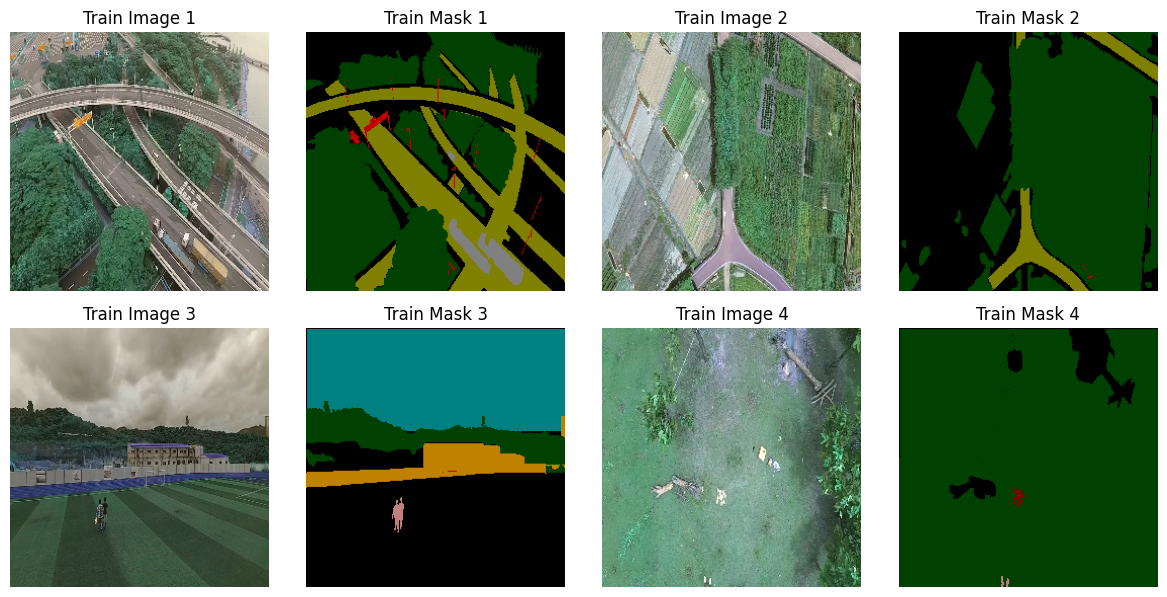

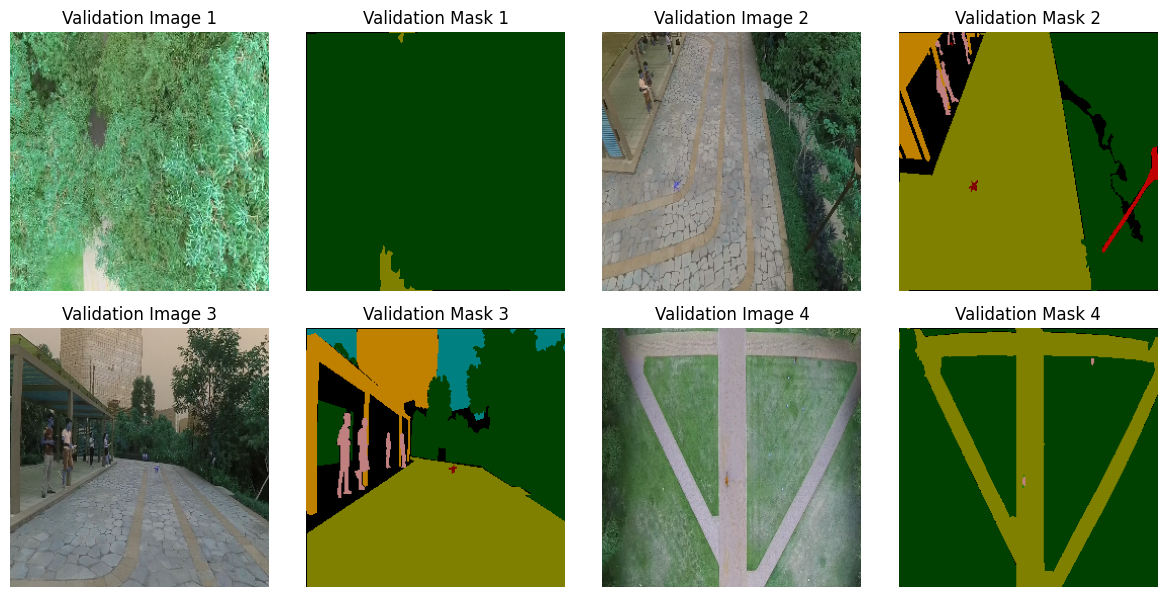

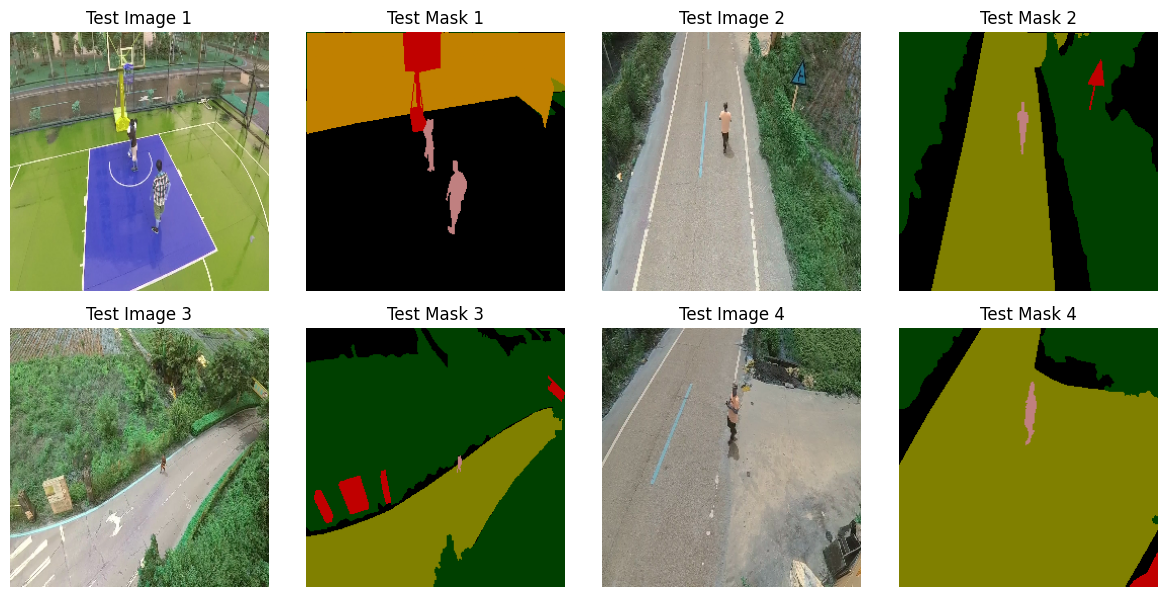

In [ ]:
# Create a custom color map based on the color_map dictionary
color_map_values = list(color_map.keys())
color_map_rgb = np.array(color_map_values) / 255.0  # Normalize to 0-1 range for matplotlib

def plot_samples_with_labels(dataset, title):
    plt.figure(figsize=(12, 12))
    for i, (images, masks) in enumerate(dataset.take(1)):  # Take a single batch
        for j in range(4):  # Loop over first four images
            # Plot the image
            plt.subplot(4, 4, j*2 + 1)
            plt.imshow(images[j].numpy())
            plt.axis("off")
            plt.title(f"{['Train', 'Validation', 'Test'][title]} Image {j+1}")

            # Convert one-hot mask back to class indices
            class_indices = np.argmax(masks[j].numpy(), axis=-1)

            # Convert class indices to RGB colors
            mask_rgb = np.zeros((height, width, 3), dtype=np.float32)
            for idx, color in enumerate(color_map_rgb):
                mask_rgb[class_indices == idx] = color

            # Plot the label mask
            plt.subplot(4, 4, j*2 + 2)
            plt.imshow(mask_rgb)
            plt.axis("off")
            plt.title(f"{['Train', 'Validation', 'Test'][title]} Mask {j+1}")
    
    plt.tight_layout()
    plt.show()


# Plot the images and corresponding label masks for each dataset
plot_samples_with_labels(train_dataset, title=0)   # Train images and masks
plot_samples_with_labels(valid_dataset, title=1)   # Validation images and masks
plot_samples_with_labels(test_dataset, title=2)    # Test images and masks

In [12]:
def channel_attention(input_tensor, reduction_ratio=16):
    channel = input_tensor.shape[-1]
    print(channel)
#     print(reduction_ratio)

    shared_dense_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_dense_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_tensor)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_dense_one(avg_pool)
    avg_pool = shared_dense_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_tensor)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_dense_one(max_pool)
    max_pool = shared_dense_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)  # Use Keras activation here

    return multiply([input_tensor, cbam_feature])

In [13]:
@tf.keras.utils.register_keras_serializable(package='Custom', name='reduce_mean')
def custom_reduce_mean(x):
    return tf.reduce_mean(x, axis=-1, keepdims=True)

@tf.keras.utils.register_keras_serializable(package='Custom', name='reduce_max')
def custom_reduce_max(x):
    return tf.reduce_max(x, axis=-1, keepdims=True)

def spatial_attention(input_tensor):
    kernel_size = 3

    avg_pool = Lambda(custom_reduce_mean, output_shape=lambda s: (s[0], s[1], s[2], 1))(input_tensor)
    max_pool = Lambda(custom_reduce_max, output_shape=lambda s: (s[0], s[1], s[2], 1))(input_tensor)

    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)

    return multiply([input_tensor, cbam_feature])

In [14]:
def cbam_module(input_tensor, reduction_ratio=16):
    cbam_feature = channel_attention(input_tensor, reduction_ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

In [16]:
def conv_block(x, num_filters, act=True):
    x = L.Conv2D(num_filters, kernel_size=3, padding="same")(x)

    if act == True:
        x = L.BatchNormalization()(x)
        x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    x = conv_block(x, num_filters)
    x = cbam_module(x)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def unet3plus(input_shape, num_classes=12):
    """ Inputs """
    inputs = L.Input(input_shape, name="input_layer")

    """ Encoder """
    e1, p1 = encoder_block(inputs, 64)
    e2, p2 = encoder_block(p1, 128)
    e3, p3 = encoder_block(p2, 256)
    e4, p4 = encoder_block(p3, 512)

    """ Bottleneck """
    e5 = conv_block(p4, 1024)
    e5 = cbam_module(e5)
    e5 = conv_block(e5, 1024)

    """ Decoder 4 """
    e1_d4 = L.MaxPool2D((8, 8))(e1)
    e1_d4 = conv_block(e1_d4, 64)

    e2_d4 = L.MaxPool2D((4, 4))(e2)
    e2_d4 = conv_block(e2_d4, 64)

    e3_d4 = L.MaxPool2D((2, 2))(e3)
    e3_d4 = conv_block(e3_d4, 64)

    e4_d4 = conv_block(e4, 64)

    e5_d4 = L.UpSampling2D((2, 2), interpolation="bilinear")(e5)
    e5_d4 = conv_block(e5_d4, 64)

    d4 = L.Concatenate()([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4])
    d4 = cbam_module(d4)
    d4 = conv_block(d4, 64*5)

    """ Decoder 3 """ #8000F8
    e1_d3 = L.MaxPool2D((4, 4))(e1)
    e1_d3 = conv_block(e1_d3, 64)

    e2_d3 = L.MaxPool2D((2, 2))(e2)
    e2_d3 = conv_block(e2_d3, 64)

    e3_d3 = conv_block(e3, 64)

    d4_d3 = L.UpSampling2D((2, 2), interpolation="bilinear")(d4)
    d4_d3 = conv_block(d4_d3, 64)

    e5_d3 = L.UpSampling2D((4, 4), interpolation="bilinear")(e5)
    e5_d3 = conv_block(e5_d3, 64)

    d3 = L.Concatenate()([e1_d3, e2_d3, e3_d3, d4_d3, e5_d3])
    d3 = cbam_module(d3)
    d3 = conv_block(d3, 64*5)

    """ Decoder 2 """
    e1_d2 = L.MaxPool2D((2, 2))(e1)
    e1_d2 = conv_block(e1_d2, 64)

    e2_d2 = conv_block(e2, 64)

    d3_d2 = L.UpSampling2D((2, 2), interpolation="bilinear")(d3)
    d3_d2 = conv_block(d3_d2, 64)

    d4_d2 = L.UpSampling2D((4, 4), interpolation="bilinear")(d4)
    d4_d2 = conv_block(d4_d2, 64)

    e5_d2 = L.UpSampling2D((8, 8), interpolation="bilinear")(e5)
    e5_d2 = conv_block(e5_d2, 64)

    d2 = L.Concatenate()([e1_d2, e2_d2, d3_d2, d4_d2, e5_d2])
    d2 = cbam_module(d2)
    d2 = conv_block(d2, 64*5)

    """ Decoder 1 """
    e1_d1 = conv_block(e1, 64)

    d2_d1 = L.UpSampling2D((2, 2), interpolation="bilinear")(d2)
    d2_d1 = conv_block(d2_d1, 64)

    d3_d1 = L.UpSampling2D((4, 4), interpolation="bilinear")(d3)
    d3_d1 = conv_block(d3_d1, 64)

    d4_d1 = L.UpSampling2D((8, 8), interpolation="bilinear")(d4)
    d4_d1 = conv_block(d4_d1, 64)

    e5_d1 = L.UpSampling2D((16, 16), interpolation="bilinear")(e5)
    e5_d1 = conv_block(e5_d1, 64)

    d1 = L.Concatenate()([e1_d1, d2_d1, d3_d1, d4_d1, e5_d1])
    d1 = cbam_module(d1)
    d1 = conv_block(d1, 64*5)

    """ Output """
    y1 = L.Conv2D(num_classes, kernel_size=3, padding="same")(d1)
    y1 = L.Activation("softmax")(y1)
    outputs = [y1]

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
input_shape = (256, 256, 3)
model = unet3plus(input_shape, 12)

64
128
256
512
1024
320
320
320
320


In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ activation_1[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d      │ (None, 64)             │              0 │ activation_1[0][0]     │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 64)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 64)       │              0 │ global_max_pooling2d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 4)        │            260 │ reshape[0][0],         │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 64)       │            320 │ dense[0][0],           │
│                           │                        │                │ dense[1][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 64)       │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_1[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 1, 1, 64)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 256, 256, 64)   │              0 │ activation_1[0][0],    │
│                      

 Total params: 27,245,946 (103.94 MB)

 Trainable params: 27,232,890 (103.89 MB)

 Non-trainable params: 13,056 (51.00 KB)

In [19]:
alpha = 0.25
gamma = 2.0

# Compile the model with focal loss
opt = tf.keras.optimizers.Adam(lr)
model.compile(
    loss=tf.keras.losses.CategoricalFocalCrossentropy(
        alpha=alpha,
        gamma=gamma,
        from_logits=False  # Since we have softmax activation in the final layer
    ),
    optimizer=opt,
    metrics=['categorical_accuracy']
)

In [20]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", mode='auto', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

In [21]:
model = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/200
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.6975 - loss: 0.1230
Epoch 1: val_loss improved from inf to 0.29309, saving model to files/modified_uavid_dataset/UnetModel.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 612s 1s/step - categorical_accuracy: 0.6976 - loss: 0.1230 - val_categorical_accuracy: 0.2677 - val_loss: 0.2931 - learning_rate: 0.0010
Epoch 2/200
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.7831 - loss: 0.0717
Epoch 2: val_loss improved from 0.29309 to 0.06614, saving model to files/modified_uavid_dataset/UnetModel.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 444s 1s/step - categorical_accuracy: 0.7832 - loss: 0.0716 - val_categorical_accuracy: 0.8025 - val_loss: 0.0661 - learning_rate: 0.0010
Epoch 3/200
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.8104 - loss: 0.0605
Epoch 3: val_loss improved from 0.06614 to 0.04784, saving model to files/modified_uavid_dataset/UnetModel.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 445s 1s/st

In [ ]:
save_path = os.path.join("Prediction", "modified_uavid_dataset")
model_file = "/kaggle/working/files/modified_uavid_dataset/UnetModel.keras"
create_dir(save_path)

In [ ]:
tf.keras.config.enable_unsafe_deserialization()
custom_objects = {
    "custom_reduce_mean": custom_reduce_mean,
    "custom_reduce_max": custom_reduce_max
}
model = tf.keras.models.load_model(model_file, custom_objects=custom_objects)

Index(['epoch', 'categorical_accuracy', 'learning_rate', 'loss',
       'val_categorical_accuracy', 'val_loss'],
      dtype='object')


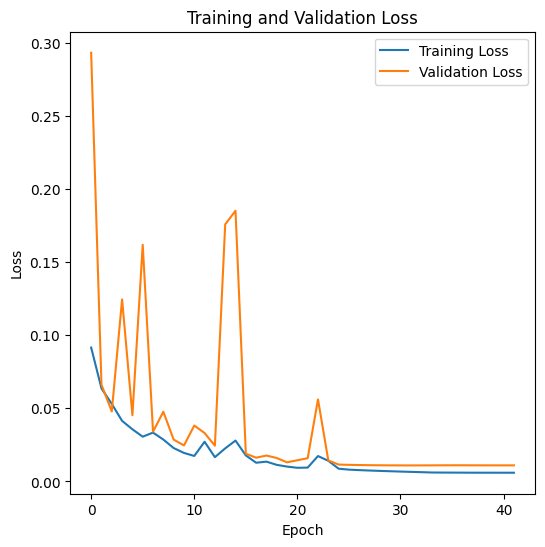

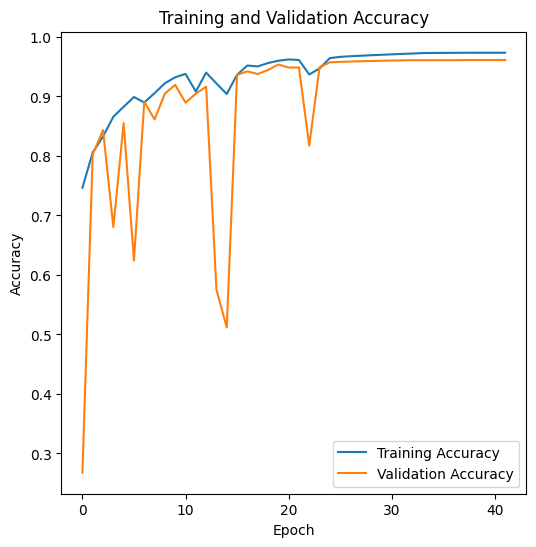

In [ ]:
import pandas as pd
# Load the CSV log file
log_file = os.path.join(files_dir, "Log-Unet.csv")
log_data = pd.read_csv(log_file)
# Check available columns in the CSV
print(log_data.columns)

# Plot Training and Validation Loss
plt.figure(figsize=(6, 6))
plt.plot(log_data['loss'], label='Training Loss')
plt.plot(log_data['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Save the Loss plot
loss_plot_file_path = os.path.join(files_dir, 'training_validation_loss.png')
plt.savefig(loss_plot_file_path)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(6, 6))
plt.plot(log_data['categorical_accuracy'], label='Training Accuracy')
plt.plot(log_data['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Save the Accuracy plot
accuracy_plot_file_path = os.path.join(files_dir, 'training_validation_accuracy.png')
plt.savefig(accuracy_plot_file_path)  # Close the figure to free memory
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


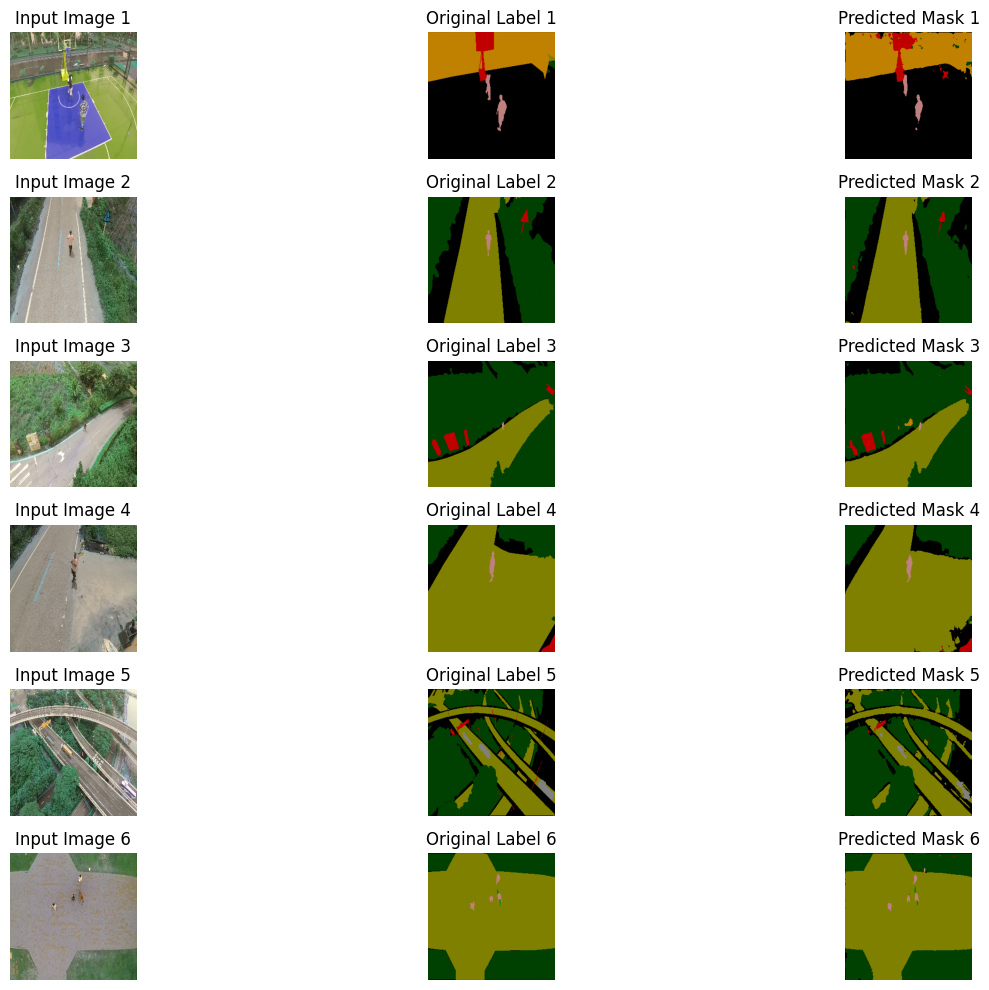

In [ ]:
class_to_rgb = {v: k for k, v in color_map.items()}

class_colors = {k: tuple(v/255.0 for v in rgb) for k, rgb in class_to_rgb.items()}
colors = np.array([class_colors[i] for i in sorted(class_colors.keys())])
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(class_colors)+1) - 0.5, ncolors=len(class_colors))

def map_class_to_rgb(class_mask):
    rgb_mask = np.zeros((class_mask.shape[0], class_mask.shape[1], 3), dtype=np.uint8)
    for class_index, rgb in class_to_rgb.items():
        rgb_mask[class_mask == class_index] = rgb
    return rgb_mask


plt.figure(figsize=(15, 10))  

batch = next(iter(test_dataset)) 
batch_x, batch_y = batch

num_images = batch_x.shape[0]

for i in range(num_images):

    image = batch_x[i].numpy()
    mask = batch_y[i].numpy()


    prediction = model.predict(np.expand_dims(image, axis=0))[0]  
    predicted_class_indices = np.argmax(prediction, axis=-1) 

    predicted_mask_rgb = map_class_to_rgb(predicted_class_indices)

    original_label_path = test_y[i] 
    original_label = cv2.imread(original_label_path, cv2.IMREAD_COLOR)
    original_label = cv2.cvtColor(original_label, cv2.COLOR_BGR2RGB)
    original_label = cv2.resize(original_label, (width, height)) / 255.0

    plt.subplot(num_images, 3, 3*i + 1)
    plt.imshow(image)
    plt.title(f"Input Image {i+1}")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 2)
    plt.imshow(original_label)
    plt.title(f"Original Label {i+1}")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 3)
    plt.imshow(predicted_mask_rgb)
    plt.title(f"Predicted Mask {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
time_taken = []
for x in tqdm(test_x):
    
    seq_folder = x.split("/")[-3]
    image_name = x.split("/")[-1]
    
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = np.expand_dims(x, axis=0)

    start_time = time.time()
    p = model.predict(x)[0] 
    total_time = time.time() - start_time
    time_taken.append(total_time)

    p_class_indices = np.argmax(p, axis=-1)  
    
    p_rgb = np.zeros((p_class_indices.shape[0], p_class_indices.shape[1], 3), dtype=np.uint8)
    
    for rgb, idx in color_map.items():
        p_rgb[p_class_indices == idx] = rgb 
    
    p_rgb = cv2.cvtColor(p_rgb, cv2.COLOR_RGB2BGR)

    save_path_with_name = os.path.join(save_path, f"{seq_folder}_{image_name}")
    cv2.imwrite(save_path_with_name, p_rgb)

  0%|          | 0/327 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 1/327 [00:00<00:47,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 2/327 [00:00<00:46,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 3/327 [00:00<00:45,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|          | 4/327 [00:00<00:44,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 5/327 [00:00<00:44,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▏         | 6/327 [00:00<00:44,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▏         | 7/327 [00:00<00:43,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▏         | 8/327 [00:01<00:43,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 9/327 [00:01<00:43,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 10/327 [00:01<00:43,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 11/327 [00:01<00:43,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|▎         | 12/327 [00:01<00:44,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 13/327 [00:01<00:44,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|▍         | 14/327 [00:01<00:44,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▍         | 15/327 [00:02<00:44,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 16/327 [00:02<00:45,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▌         | 17/327 [00:02<00:44,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 18/327 [00:02<00:44,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  6%|▌         | 19/327 [00:02<00:45,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▌         | 20/327 [00:02<00:44,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▋         | 21/327 [00:02<00:44,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|▋         | 22/327 [00:03<00:44,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|▋         | 23/327 [00:03<00:44,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|▋         | 24/327 [00:03<00:43,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 25/327 [00:03<00:44,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 26/327 [00:03<00:44,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 27/327 [00:03<00:44,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|▊         | 28/327 [00:04<00:43,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▉         | 29/327 [00:04<00:43,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|▉         | 30/327 [00:04<00:43,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|▉         | 31/327 [00:04<00:43,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|▉         | 32/327 [00:04<00:42,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|█         | 33/327 [00:04<00:42,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|█         | 34/327 [00:04<00:42,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|█         | 35/327 [00:05<00:41,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|█         | 36/327 [00:05<00:41,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|█▏        | 37/327 [00:05<00:41,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 38/327 [00:05<00:41,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 39/327 [00:05<00:42,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 40/327 [00:05<00:41,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 41/327 [00:05<00:41,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|█▎        | 42/327 [00:06<00:41,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 43/327 [00:06<00:41,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|█▎        | 44/327 [00:06<00:41,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|█▍        | 45/327 [00:06<00:41,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|█▍        | 46/327 [00:06<00:40,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|█▍        | 47/327 [00:06<00:40,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|█▍        | 48/327 [00:06<00:40,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▍        | 49/327 [00:07<00:39,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|█▌        | 50/327 [00:07<00:39,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 51/327 [00:07<00:40,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 52/327 [00:07<00:40,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 53/327 [00:07<00:40,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 54/327 [00:07<00:40,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|█▋        | 55/327 [00:07<00:39,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 56/327 [00:08<00:39,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|█▋        | 57/327 [00:08<00:39,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 58/327 [00:08<00:39,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 59/327 [00:08<00:39,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 60/327 [00:08<00:39,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|█▊        | 61/327 [00:08<00:38,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|█▉        | 62/327 [00:08<00:38,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|█▉        | 63/327 [00:09<00:38,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|█▉        | 64/327 [00:09<00:38,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|█▉        | 65/327 [00:09<00:38,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|██        | 66/327 [00:09<00:38,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|██        | 67/327 [00:09<00:37,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|██        | 68/327 [00:09<00:37,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|██        | 69/327 [00:09<00:37,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|██▏       | 70/327 [00:10<00:37,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 22%|██▏       | 71/327 [00:10<00:37,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 72/327 [00:10<00:37,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 22%|██▏       | 73/327 [00:10<00:37,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 74/327 [00:10<00:37,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|██▎       | 75/327 [00:10<00:37,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 76/327 [00:11<00:37,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▎       | 77/327 [00:11<00:37,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 78/327 [00:11<00:36,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 79/327 [00:11<00:36,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 24%|██▍       | 80/327 [00:11<00:36,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▍       | 81/327 [00:11<00:35,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|██▌       | 82/327 [00:11<00:35,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▌       | 83/327 [00:12<00:35,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▌       | 84/327 [00:12<00:35,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▌       | 85/327 [00:12<00:35,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|██▋       | 86/327 [00:12<00:35,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██▋       | 87/327 [00:12<00:35,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██▋       | 88/327 [00:12<00:35,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 89/327 [00:12<00:35,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 90/327 [00:13<00:36,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|██▊       | 91/327 [00:13<00:35,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 92/327 [00:13<00:35,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 93/327 [00:13<00:35,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▊       | 94/327 [00:13<00:34,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▉       | 95/327 [00:13<00:34,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|██▉       | 96/327 [00:13<00:33,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|██▉       | 97/327 [00:14<00:33,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|██▉       | 98/327 [00:14<00:33,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|███       | 99/327 [00:14<00:33,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 100/327 [00:14<00:33,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███       | 101/327 [00:14<00:33,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 102/327 [00:14<00:32,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███▏      | 103/327 [00:14<00:32,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 104/327 [00:15<00:32,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 105/327 [00:15<00:32,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███▏      | 106/327 [00:15<00:32,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|███▎      | 107/327 [00:15<00:31,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|███▎      | 108/327 [00:15<00:31,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 109/327 [00:15<00:31,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|███▎      | 110/327 [00:15<00:31,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 111/327 [00:16<00:31,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 112/327 [00:16<00:31,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▍      | 113/327 [00:16<00:31,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▍      | 114/327 [00:16<00:31,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▌      | 115/327 [00:16<00:31,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▌      | 116/327 [00:16<00:30,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███▌      | 117/327 [00:17<00:30,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███▌      | 118/327 [00:17<00:30,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███▋      | 119/327 [00:17<00:30,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 37%|███▋      | 120/327 [00:17<00:29,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 37%|███▋      | 121/327 [00:17<00:30,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|███▋      | 122/327 [00:17<00:29,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 38%|███▊      | 123/327 [00:17<00:29,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 124/327 [00:18<00:29,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 38%|███▊      | 125/327 [00:18<00:29,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|███▊      | 126/327 [00:18<00:28,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 39%|███▉      | 127/327 [00:18<00:30,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 39%|███▉      | 128/327 [00:18<00:29,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 39%|███▉      | 129/327 [00:18<00:29,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 40%|███▉      | 130/327 [00:18<00:28,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|████      | 131/327 [00:19<00:28,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|████      | 132/327 [00:19<00:28,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████      | 133/327 [00:19<00:28,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 41%|████      | 134/327 [00:19<00:28,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 41%|████▏     | 135/327 [00:19<00:29,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 42%|████▏     | 136/327 [00:19<00:29,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 137/327 [00:19<00:29,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 138/327 [00:20<00:29,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 43%|████▎     | 139/327 [00:20<00:29,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 140/327 [00:20<00:28,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 141/327 [00:20<00:28,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 142/327 [00:20<00:28,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▎     | 143/327 [00:20<00:28,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▍     | 144/327 [00:21<00:27,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▍     | 145/327 [00:21<00:27,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████▍     | 146/327 [00:21<00:27,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|████▍     | 147/327 [00:21<00:27,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 45%|████▌     | 148/327 [00:21<00:26,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 46%|████▌     | 149/327 [00:21<00:26,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 46%|████▌     | 150/327 [00:21<00:26,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 46%|████▌     | 151/327 [00:22<00:25,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████▋     | 152/327 [00:22<00:25,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 47%|████▋     | 153/327 [00:22<00:25,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|████▋     | 154/327 [00:22<00:25,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|████▋     | 155/327 [00:22<00:26,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 48%|████▊     | 156/327 [00:22<00:26,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 48%|████▊     | 157/327 [00:23<00:25,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|████▊     | 158/327 [00:23<00:25,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 49%|████▊     | 159/327 [00:23<00:25,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 49%|████▉     | 160/327 [00:23<00:24,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 49%|████▉     | 161/327 [00:23<00:24,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 50%|████▉     | 162/327 [00:23<00:24,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 50%|████▉     | 163/327 [00:23<00:24,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|█████     | 164/327 [00:24<00:24,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 50%|█████     | 165/327 [00:24<00:23,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████     | 166/327 [00:24<00:23,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████     | 167/327 [00:24<00:23,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 51%|█████▏    | 168/327 [00:24<00:23,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 52%|█████▏    | 169/327 [00:24<00:22,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|█████▏    | 170/327 [00:24<00:22,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|█████▏    | 171/327 [00:25<00:22,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 172/327 [00:25<00:22,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 173/327 [00:25<00:22,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 174/327 [00:25<00:22,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|█████▎    | 175/327 [00:25<00:22,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|█████▍    | 176/327 [00:25<00:22,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|█████▍    | 177/327 [00:25<00:22,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|█████▍    | 178/327 [00:26<00:21,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████▍    | 179/327 [00:26<00:21,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████▌    | 180/327 [00:26<00:21,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████▌    | 181/327 [00:26<00:21,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|█████▌    | 182/327 [00:26<00:20,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|█████▌    | 183/327 [00:26<00:21,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|█████▋    | 184/327 [00:26<00:20,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 57%|█████▋    | 185/327 [00:27<00:20,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|█████▋    | 186/327 [00:27<00:20,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 57%|█████▋    | 187/327 [00:27<00:20,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|█████▋    | 188/327 [00:27<00:20,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 189/327 [00:27<00:20,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|█████▊    | 190/327 [00:27<00:20,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|█████▊    | 191/327 [00:27<00:19,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████▊    | 192/327 [00:28<00:19,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████▉    | 193/327 [00:28<00:19,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████▉    | 194/327 [00:28<00:19,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|█████▉    | 195/327 [00:28<00:19,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|█████▉    | 196/327 [00:28<00:19,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|██████    | 197/327 [00:28<00:18,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████    | 198/327 [00:29<00:18,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|██████    | 199/327 [00:29<00:18,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████    | 200/327 [00:29<00:18,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████▏   | 201/327 [00:29<00:18,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|██████▏   | 202/327 [00:29<00:18,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|██████▏   | 203/327 [00:29<00:17,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|██████▏   | 204/327 [00:29<00:17,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|██████▎   | 205/327 [00:30<00:17,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|██████▎   | 206/327 [00:30<00:17,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 63%|██████▎   | 207/327 [00:30<00:17,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████▎   | 208/327 [00:30<00:17,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 64%|██████▍   | 209/327 [00:30<00:17,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████▍   | 210/327 [00:30<00:16,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|██████▍   | 211/327 [00:30<00:16,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▍   | 212/327 [00:31<00:16,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▌   | 213/327 [00:31<00:16,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 65%|██████▌   | 214/327 [00:31<00:16,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|██████▌   | 215/327 [00:31<00:16,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|██████▌   | 216/327 [00:31<00:16,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|██████▋   | 217/327 [00:31<00:16,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|██████▋   | 218/327 [00:31<00:16,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|██████▋   | 219/327 [00:32<00:16,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|██████▋   | 220/327 [00:32<00:15,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 221/327 [00:32<00:15,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 222/327 [00:32<00:15,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 68%|██████▊   | 223/327 [00:32<00:15,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|██████▊   | 224/327 [00:32<00:15,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 225/327 [00:32<00:15,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 69%|██████▉   | 226/327 [00:33<00:14,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 227/327 [00:33<00:14,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 70%|██████▉   | 228/327 [00:33<00:14,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|███████   | 229/327 [00:33<00:14,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|███████   | 230/327 [00:33<00:14,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████   | 231/327 [00:33<00:14,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|███████   | 232/327 [00:33<00:13,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████▏  | 233/327 [00:34<00:13,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████▏  | 234/327 [00:34<00:13,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 72%|███████▏  | 235/327 [00:34<00:13,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████▏  | 236/327 [00:34<00:13,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 72%|███████▏  | 237/327 [00:34<00:13,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|███████▎  | 238/327 [00:34<00:13,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|███████▎  | 239/327 [00:35<00:12,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|███████▎  | 240/327 [00:35<00:12,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████▎  | 241/327 [00:35<00:12,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████▍  | 242/327 [00:35<00:12,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████▍  | 243/327 [00:35<00:12,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 75%|███████▍  | 244/327 [00:35<00:12,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▍  | 245/327 [00:35<00:11,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|███████▌  | 246/327 [00:36<00:11,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▌  | 247/327 [00:36<00:11,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 76%|███████▌  | 248/327 [00:36<00:11,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▌  | 249/327 [00:36<00:11,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 76%|███████▋  | 250/327 [00:36<00:11,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|███████▋  | 251/327 [00:36<00:10,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|███████▋  | 252/327 [00:36<00:10,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|███████▋  | 253/327 [00:37<00:10,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████▊  | 254/327 [00:37<00:10,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████▊  | 255/327 [00:37<00:10,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████▊  | 256/327 [00:37<00:10,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 79%|███████▊  | 257/327 [00:37<00:10,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 79%|███████▉  | 258/327 [00:37<00:10,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|███████▉  | 259/327 [00:37<00:09,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|███████▉  | 260/327 [00:38<00:09,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|███████▉  | 261/327 [00:38<00:09,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|████████  | 262/327 [00:38<00:09,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|████████  | 263/327 [00:38<00:09,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|████████  | 264/327 [00:38<00:09,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 81%|████████  | 265/327 [00:38<00:08,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|████████▏ | 266/327 [00:38<00:08,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|████████▏ | 267/327 [00:39<00:08,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 82%|████████▏ | 268/327 [00:39<00:08,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 82%|████████▏ | 269/327 [00:39<00:08,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████▎ | 270/327 [00:39<00:08,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████▎ | 271/327 [00:39<00:08,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 83%|████████▎ | 272/327 [00:39<00:07,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████▎ | 273/327 [00:39<00:07,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▍ | 274/327 [00:40<00:07,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|████████▍ | 275/327 [00:40<00:07,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|████████▍ | 276/327 [00:40<00:07,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|████████▍ | 277/327 [00:40<00:07,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 85%|████████▌ | 278/327 [00:40<00:06,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|████████▌ | 279/327 [00:40<00:06,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|████████▌ | 280/327 [00:40<00:06,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|████████▌ | 281/327 [00:41<00:06,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|████████▌ | 282/327 [00:41<00:06,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 87%|████████▋ | 283/327 [00:41<00:06,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 87%|████████▋ | 284/327 [00:41<00:06,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████▋ | 285/327 [00:41<00:06,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 286/327 [00:41<00:05,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 88%|████████▊ | 287/327 [00:41<00:05,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|████████▊ | 288/327 [00:42<00:05,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|████████▊ | 289/327 [00:42<00:05,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|████████▊ | 290/327 [00:42<00:05,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|████████▉ | 291/327 [00:42<00:05,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 89%|████████▉ | 292/327 [00:42<00:05,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|████████▉ | 293/327 [00:42<00:04,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 90%|████████▉ | 294/327 [00:42<00:04,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 90%|█████████ | 295/327 [00:43<00:04,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████ | 296/327 [00:43<00:04,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|█████████ | 297/327 [00:43<00:04,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|█████████ | 298/327 [00:43<00:04,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|█████████▏| 299/327 [00:43<00:04,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 92%|█████████▏| 300/327 [00:43<00:03,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 301/327 [00:43<00:03,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|█████████▏| 302/327 [00:44<00:03,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|█████████▎| 303/327 [00:44<00:03,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 93%|█████████▎| 304/327 [00:44<00:03,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|█████████▎| 305/327 [00:44<00:03,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|█████████▎| 306/327 [00:44<00:03,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 94%|█████████▍| 307/327 [00:44<00:02,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|█████████▍| 308/327 [00:44<00:02,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 94%|█████████▍| 309/327 [00:45<00:02,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|█████████▍| 310/327 [00:45<00:02,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|█████████▌| 311/327 [00:45<00:02,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▌| 312/327 [00:45<00:02,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████▌| 313/327 [00:45<00:02,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 96%|█████████▌| 314/327 [00:45<00:01,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 96%|█████████▋| 315/327 [00:46<00:01,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|█████████▋| 316/327 [00:46<00:01,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████▋| 317/327 [00:46<00:01,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████▋| 318/327 [00:46<00:01,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 98%|█████████▊| 319/327 [00:46<00:01,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|█████████▊| 320/327 [00:46<00:01,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|█████████▊| 321/327 [00:46<00:00,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|█████████▊| 322/327 [00:47<00:00,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|█████████▉| 323/327 [00:47<00:00,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 324/327 [00:47<00:00,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 325/327 [00:47<00:00,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|█████████▉| 326/327 [00:47<00:00,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|██████████| 327/327 [00:47<00:00,  6.85it/s]


In [27]:
!zip -r file.zip /kaggle/working
from IPython.display import FileLink
FileLink(r'file.zip')

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/files/ (stored 0%)
  adding: kaggle/working/files/modified_uavid_dataset/ (stored 0%)
  adding: kaggle/working/files/modified_uavid_dataset/UnetModel.keras (deflated 6%)
  adding: kaggle/working/files/modified_uavid_dataset/training_validation_loss.png (deflated 10%)
  adding: kaggle/working/files/modified_uavid_dataset/training_validation_accuracy.png (deflated 9%)
  adding: kaggle/working/files/modified_uavid_dataset/Log-Unet.csv (deflated 59%)
  adding: kaggle/working/Prediction/ (stored 0%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/ (stored 0%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/aeroscapes_000101_005.jpg (deflated 2%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/aeroscapes_000004_025.jpg (deflated 9%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/aeroscapes_315000_016.jpg (deflated 9%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/aeroscape

/kaggle/working/file.zip